# Image Compression with Principle Component Analysis
Principle component analysis (PCA) is a common dimension reduction technique. When running PCA, we first find a basis of vectors (the principle components) that explains most of the variance in the original dataset, then project the original dataset into this lower-dimensional space. While more common in other fields, this technique can also be applied to image compression -- reducing the dimensionality of the image means it takes less space to store, and by only removing components that account for the least variance, we can preserve the original image. 

Up to a constant, the covariance matrix is defined as
$$ cov(X) = X X^T = X^T X,$$
since the covariance is symmetric. Note that the variance of dimensions fall on the diagonal and covariances are on the off-diagonals. The goal of PCA is to map an `m*n` matrix `X` onto a lower dimensional `m*k` matrix `Z` in which each dimension has maximal variance and no covariance; ie `cov(Z)` is diagonalized. To do this we must find a `n*k` projection matrix `V` such that $$Z_{m*k}=X_{m*n}V_{n*k}.$$

In order to pick `V` such that diagonalizes `cov(Z)`, note that
$$cov(Z) = (VX)(VX)^T = V X X^T V^T = V cov(X) V^T.$$
Since `cov(X)` is symmetric, it is orthogonal diagonalizable by the spectral theorem (http://www.maths.manchester.ac.uk/~peter/MATH10212/notes10.pdf). Therefore there exists an orthogonal matrix `V` (the eigenvectors of `X`) such that
$$cov(Z) = P (P^T D P) P^T = (PP^T)D(PP^T) = D,$$
where `D` has the eigenvalues of `X` along its diagonal (https://medium.com/@aptrishu/understanding-principle-component-analysis-e32be0253ef0).

Therefore we pick `V` to be the eigenvectors of `cov(X)` in order to diagonalize `cov(Z)`. These eigenvectors will form the new basis of reduced-dimension data, and their eigenvalues weight the importance of each. In order to reduce `Z` to `n*k` dimensions, we therefore remove from `V` all but the `k` eigenvectors with the greatest eigenvalues.

In order to re-project the reduced-dimension data into the original number of dimensions, we simply project it onto `V^T`. Therefore
$$\hat{X}_{m*n} = Z_{m*k} V^T_{k*n}.$$

In addition to the sources mentioned above, a very good overview of this technique can be found at http://www.dsc.ufcg.edu.br/~hmg/disciplinas/posgraduacao/rn-copin-2014.3/material/SignalProcPCA.pdf.
I also used some code snippets from https://plot.ly/ipython-notebooks/principal-component-analysis/.

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from operator import itemgetter

In [9]:
def pca_compress(M,res):
    
    #center each column vector around 0
    #this gives a much steeper slope in the explained variance plot below
    means = np.mean(M,axis=0)
    M_ = M - means 
    
    #find eigenvectors of covariance matrix
    cov = M_.T @ M_ 
    w,v = np.linalg.eig(cov)
    
    #eigenvectors with larger eigenvalues explain more of the variance in original data, keep only top k
    aw = [np.abs(w[i]) for i in range(len(w))]
    pairs = [(aw[i],v[:,i]) for i in range(len(w))] #nb each column in v corresponds to eigenvalue w
    ordered = sorted(pairs, key=itemgetter(0), reverse=True)

    #calculate how much variance each eigenvector accounts for, and retain top res%
    total = np.sum(aw)
    evars = [aw[i]/total for i in range(len(w))]
    cum_evars = np.cumsum(evars)
    plt.plot(range(len(w)),cum_evars)
    plt.xlabel('Number of principle components')
    plt.ylabel('Cumulative explained variance')
    plt.show()
    
    N=0 #number of eigenvectors to keep
    while cum_evars[N] < res:
        N+=1
        
    top_v = np.array([ordered[i][1] for i in range(N)]).T #eigenvectors got flattened to rows when we ordered them
                                                          #so now we need to take the transpose
    proj = M_ @ top_v #project onto new eigenbasis
    ar = proj @ top_v.T + means #reconstruct original shape
    ar = ar.astype(int) #all our eigenvectors are real (ignore warning), cast as int so we can read as image
    
    return(ar,N)

We run PCA separately on each of the `R`,`G`,and `B` matrices that compose the original image:

In [10]:
img = cv2.imread("./kodim07.png")
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

res = 0.95

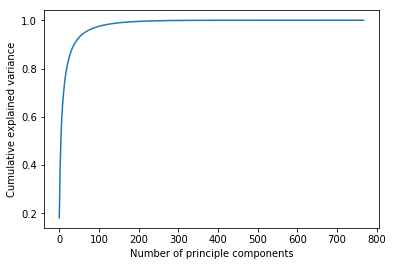

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


In [11]:
Rar,RN = pca_compress(R,res)

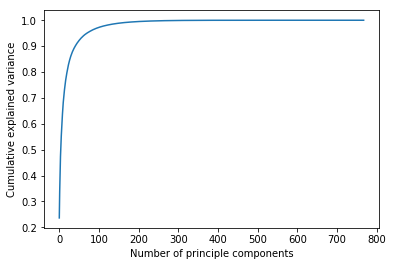

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


In [12]:
Gar,GN = pca_compress(G,res)

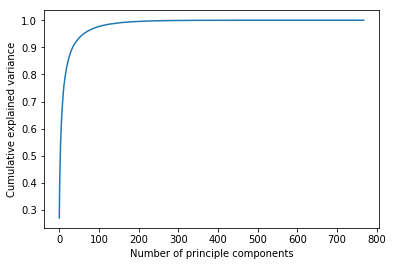

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


In [13]:
Bar,BN = pca_compress(B,res)

In [15]:
ar_full = np.zeros(img.shape)
ar_full[:,:,0] = Rar
ar_full[:,:,1] = Gar
ar_full[:,:,2] = Bar
cv2.imwrite("./kodim07_pcatest_"+str(res)+".png",ar_full)

True

To calculate the compression ratio, note that we can represent the compressed form of an original `m*n` image with the `n*k` matrix `proj`, the `m*k` matrix `top_v`, and the `1*n` matrix `means`. In our case `n>m`, and so we only need `(2k+1)*n` values to reconstruct the original image. This is less than the `m*n*3` values needed to represent the original image.  

In [16]:
original = img.shape[0] * 3
after = (2*RN + 1)+(2*GN + 1)+(2*BN +1)
compression_ratio = original/after
print(compression_ratio)

3.8690176322418135
